# DipC clustering at 100kb resolution

In [1]:
import time
import numpy as np
import pandas as pd
from glob import glob
import anndata
import scanpy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import cm as cm
import seaborn as sns
from scipy.sparse import csr_matrix
from ALLCools.plot import *
from ALLCools.clustering import *
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize

mpl.style.use('default')
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'Helvetica'


In [2]:
indir = '/data/test_schicluster/Tan2021/scool/dataset/'

In [3]:
chrom_sizes = pd.read_csv('/data/ref/mm10/genome/mm10.autosome.chrom.sizes', index_col=0, header=None, sep='\t')[1]
chrom_sizes

0
chr1     195471971
chr2     182113224
chr3     160039680
chr4     156508116
chr5     151834684
chr6     149736546
chr7     145441459
chr8     129401213
chr9     124595110
chr10    130694993
chr11    122082543
chr12    120129022
chr13    120421639
chr14    124902244
chr15    104043685
chr16     98207768
chr17     94987271
chr18     90702639
chr19     61431566
Name: 1, dtype: int64

In [4]:
celllist = pd.read_csv(f'{indir}../impute/100K/cell_table.tsv', sep='\t', index_col=0, header=None)
celllist


,1
0,
cortex-p028-cb_116,/anvil/scratch/x-zhou/Tan2021/scool/impute/100...
cortex-visual-control-p007-b6_182,/anvil/scratch/x-zhou/Tan2021/scool/impute/100...
cortex-p028-cb_112,/anvil/scratch/x-zhou/Tan2021/scool/impute/100...
cortex-visual-control-p001-b6_061,/anvil/scratch/x-zhou/Tan2021/scool/impute/100...
cortex-p056-cb_216,/anvil/scratch/x-zhou/Tan2021/scool/impute/100...
...,...
cortex-visual-control-p021-b6_090,/anvil/scratch/x-zhou/Tan2021/scool/impute/100...
cortex-visual-control-p021-b6_012,/anvil/scratch/x-zhou/Tan2021/scool/impute/100...
hippocampus-p007-cb_046,/anvil/scratch/x-zhou/Tan2021/scool/impute/100...


In [5]:
meta = pd.read_csv('meta.txt', sep='\t', header=0, index_col=0)
meta

,tissue,treatment,age,sex,father,mother,restriction enzyme,cell-type cluster,reads,read length (bp),raw throughput (Gb),raw contacts,raw intra (%),dup rate (%),contacts,intra (%),phased legs (%),raw contacts per read (%),20kb RMS RMSD
cell,,,,,,,,,,,,,,,,,,,
cortex-p001-cb_001,cortex,control,P1,female,C57BL/6J,CAST/EiJ,MboI,Neonatal Astrocyte,"13,675,687",150,4.1,"1,703,101",70.8,70.4,"503,696",68.1,47.0,12.5,0.50
cortex-p001-cb_002,cortex,control,P1,female,C57BL/6J,CAST/EiJ,MboI,Neonatal Neuron 1,"10,057,130",150,3.0,"1,202,070",76.5,68.6,"377,718",73.6,47.0,12.0,10.07
cortex-p001-cb_003,cortex,control,P1,female,C57BL/6J,CAST/EiJ,MboI,Neonatal Neuron 2,"12,673,668",150,3.8,"1,163,722",84.2,68.6,"365,317",80.2,46.5,9.2,11.35
cortex-p001-cb_004,cortex,control,P1,female,C57BL/6J,CAST/EiJ,MboI,Unknown,"12,936,354",150,3.9,"1,289,148",84.6,69.2,"396,869",81.0,46.5,10.0,14.27
cortex-p001-cb_005,cortex,control,P1,female,C57BL/6J,CAST/EiJ,MboI,Neonatal Neuron 2,"14,086,574",150,4.2,"1,510,084",76.9,71.2,"434,395",73.4,46.9,10.7,0.97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cortex-visual-dark-p028-b6_188,visual cortex,dark rearing,P28,male,C57BL/6N,C57BL/6N,NlaIII,Neuron,"5,796,965",150,1.7,"603,448",92.2,57.7,"255,561",90.4,0.0,10.4,NaN
cortex-visual-dark-p028-b6_189,visual cortex,dark rearing,P28,male,C57BL/6N,C57BL/6N,NlaIII,Neuron,"6,520,182",150,2.0,"736,632",90.6,59.8,"296,289",88.7,0.0,11.3,NaN
cortex-visual-dark-p028-b6_190,visual cortex,dark rearing,P28,male,C57BL/6N,C57BL/6N,NlaIII,Neuron,"10,724,783",150,3.2,"1,296,262",90.6,70.6,"381,381",87.9,0.0,12.1,NaN


In [6]:
start_time = time.time()
matrix = []
dim = 50
for chrom in chrom_sizes.index:
    tmp = np.load(f'{indir}embedding/raw/{chrom}.npz')['arr_0']
    dim = min(dim, tmp.shape[0] - 1, tmp.shape[1] - 1)
    model = TruncatedSVD(n_components=dim, algorithm='arpack')
    tmp_reduce = model.fit_transform(tmp)
    matrix.append(tmp_reduce / model.singular_values_)
    print(chrom, time.time() - start_time)


chr1 6.581930160522461
chr2 11.939553499221802
chr3 17.48383092880249
chr4 22.65337896347046
chr5 27.87999391555786
chr6 33.39244103431702
chr7 38.8983359336853
chr8 43.60885500907898
chr9 49.0135338306427
chr10 54.309446811676025
chr11 58.871928453445435
chr12 64.58947443962097
chr13 67.8880524635315
chr14 73.15141296386719
chr15 76.84170579910278
chr16 79.75830459594727
chr17 82.38596296310425
chr18 85.09349274635315
chr19 86.87178158760071


In [7]:
model = TruncatedSVD(n_components=dim, algorithm='arpack')
matrix_reduce = model.fit_transform(np.concatenate(matrix, axis=1))
matrix_reduce = matrix_reduce / model.singular_values_


In [8]:
adata = anndata.AnnData(X=np.ones((celllist.shape[0],1)), 
                        obs=meta.loc[celllist.index])
adata


AnnData object with n_obs × n_vars = 3646 × 1
    obs: 'tissue', 'treatment', 'age', 'sex', 'father', 'mother', 'restriction enzyme', 'cell-type cluster', 'reads', 'read length (bp)', 'raw throughput (Gb)', 'raw contacts', 'raw intra (%)', 'dup rate (%)', 'contacts', 'intra (%)', 'phased legs (%)', 'raw contacts per read (%)', '20kb RMS RMSD'

In [9]:
adata.obs.index.name = 'cell_name'
adata.obs['age'] = adata.obs['age'].str[1:].astype(int)
adata.obs['contacts'] = adata.obs['contacts'].str.replace(',','').astype(int)


In [10]:
adata.obs = adata.obs[['tissue', 'treatment', 'age', 'sex', 'father', 'mother',
                       'restriction enzyme', 'cell-type cluster', 'contacts']]

In [11]:
adata.obsm['dipc_pca_all'] = matrix_reduce.copy()

In [12]:
significant_pc_test(adata, p_cutoff=0.1, update=False, obsm='dipc_pca_all')


7 components passed P cutoff of 0.1.


7

In [13]:
adata.obsm['X_pca'] = normalize(adata.obsm['dipc_pca_all'][:, :20], axis=1)


In [14]:
def dump_embedding(adata, name, n_dim=2):
    # put manifold coordinates into adata.obs
    for i in range(n_dim):
        adata.obs[f'{name}_{i}'] = adata.obsm[f'X_{name}'][:, i]
    return adata


In [15]:
knn = 25
sc.pp.neighbors(adata, n_neighbors=knn, use_rep='X_pca')
sc.tl.umap(adata, maxiter=200, random_state=0)
adata = dump_embedding(adata, 'umap')


In [17]:
sc.tl.leiden(adata, resolution=1.0, random_state=0)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


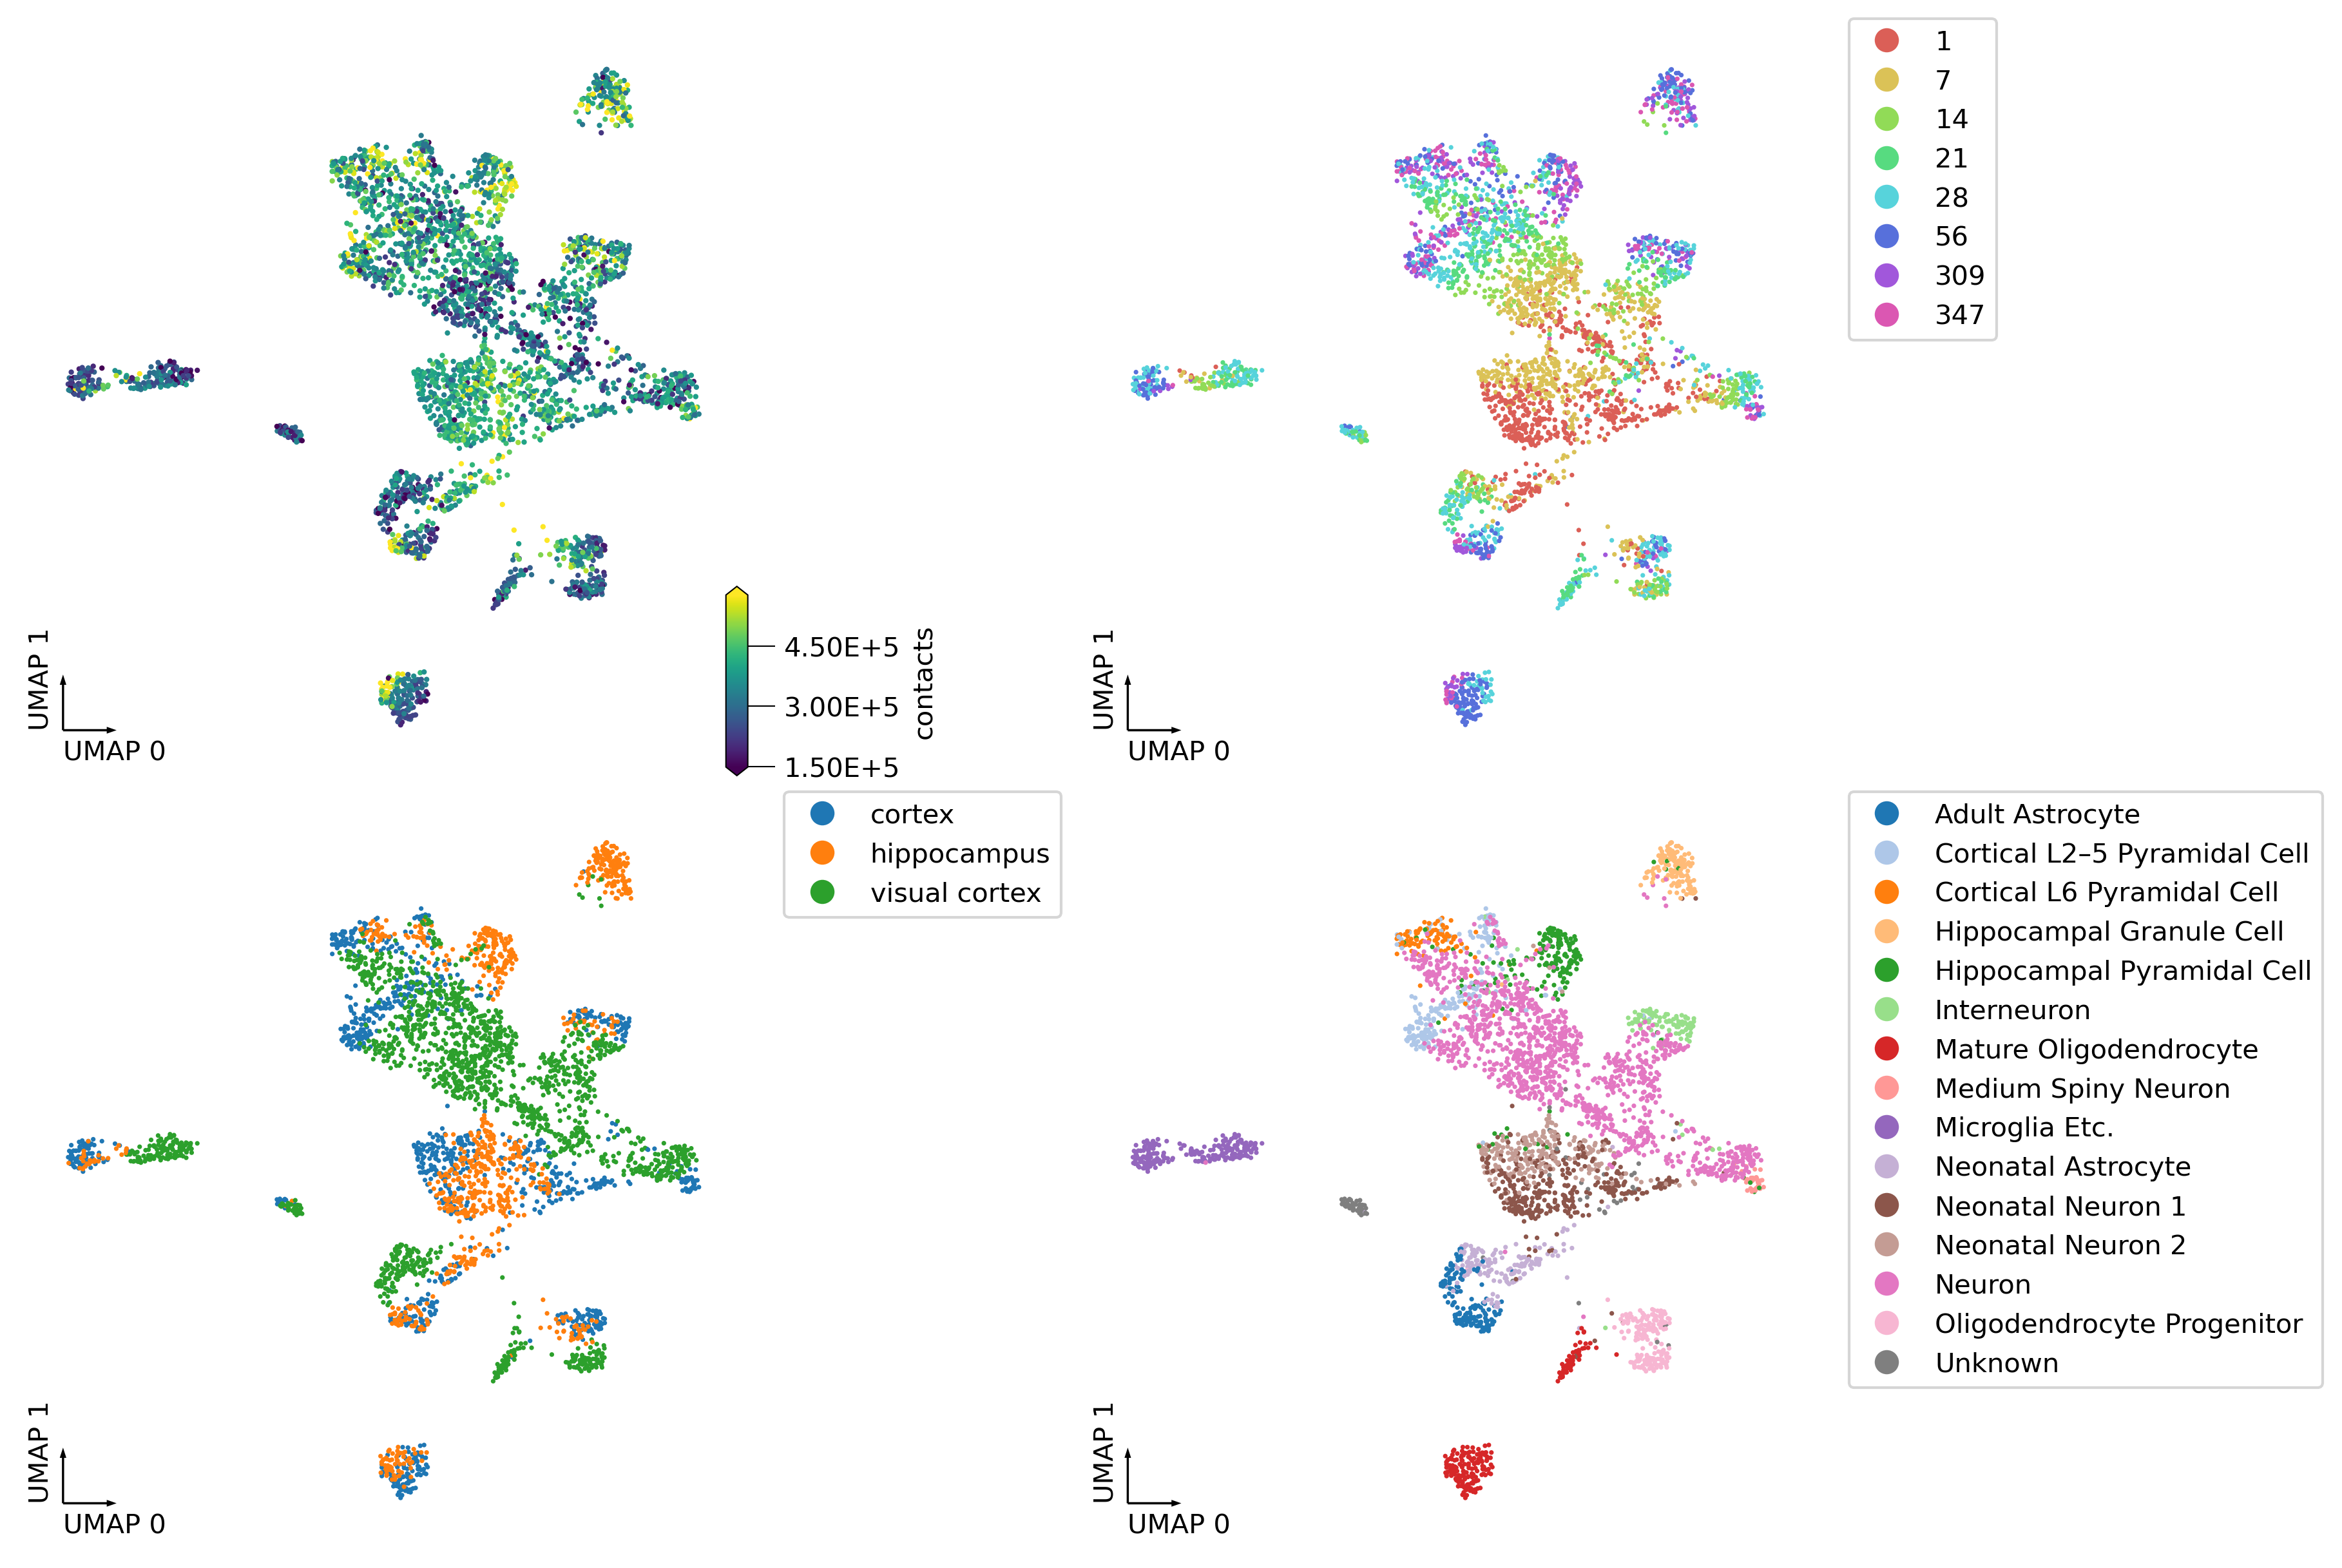

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8), dpi=300, constrained_layout=True)
_ = continuous_scatter(ax=axes[0,0],
                       data=adata.obs,
                       hue='contacts',
                       coord_base='umap',
                       #max_points=None,
                       labelsize=10,
                       s=4)
_ = categorical_scatter(data=adata.obs,
                        ax=axes[0,1],
                        coord_base='umap',
                        hue='age',
                        palette='hls',
                        labelsize=10,
                        show_legend=True)
_ = categorical_scatter(ax=axes[1,0],
                        data=adata.obs,
                        hue='tissue',
                        coord_base='umap',
                        # text_anno='region',
                        # palette='tab10',
                        labelsize=10,
                        show_legend=True
                       )
_ = categorical_scatter(ax=axes[1,1],
                        data=adata.obs,
                        hue='cell-type cluster',
                        coord_base='umap',
                        # text_anno='cell-type cluster',
                        palette='tab20',
                        labelsize=10,
                        show_legend=True
                       )


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


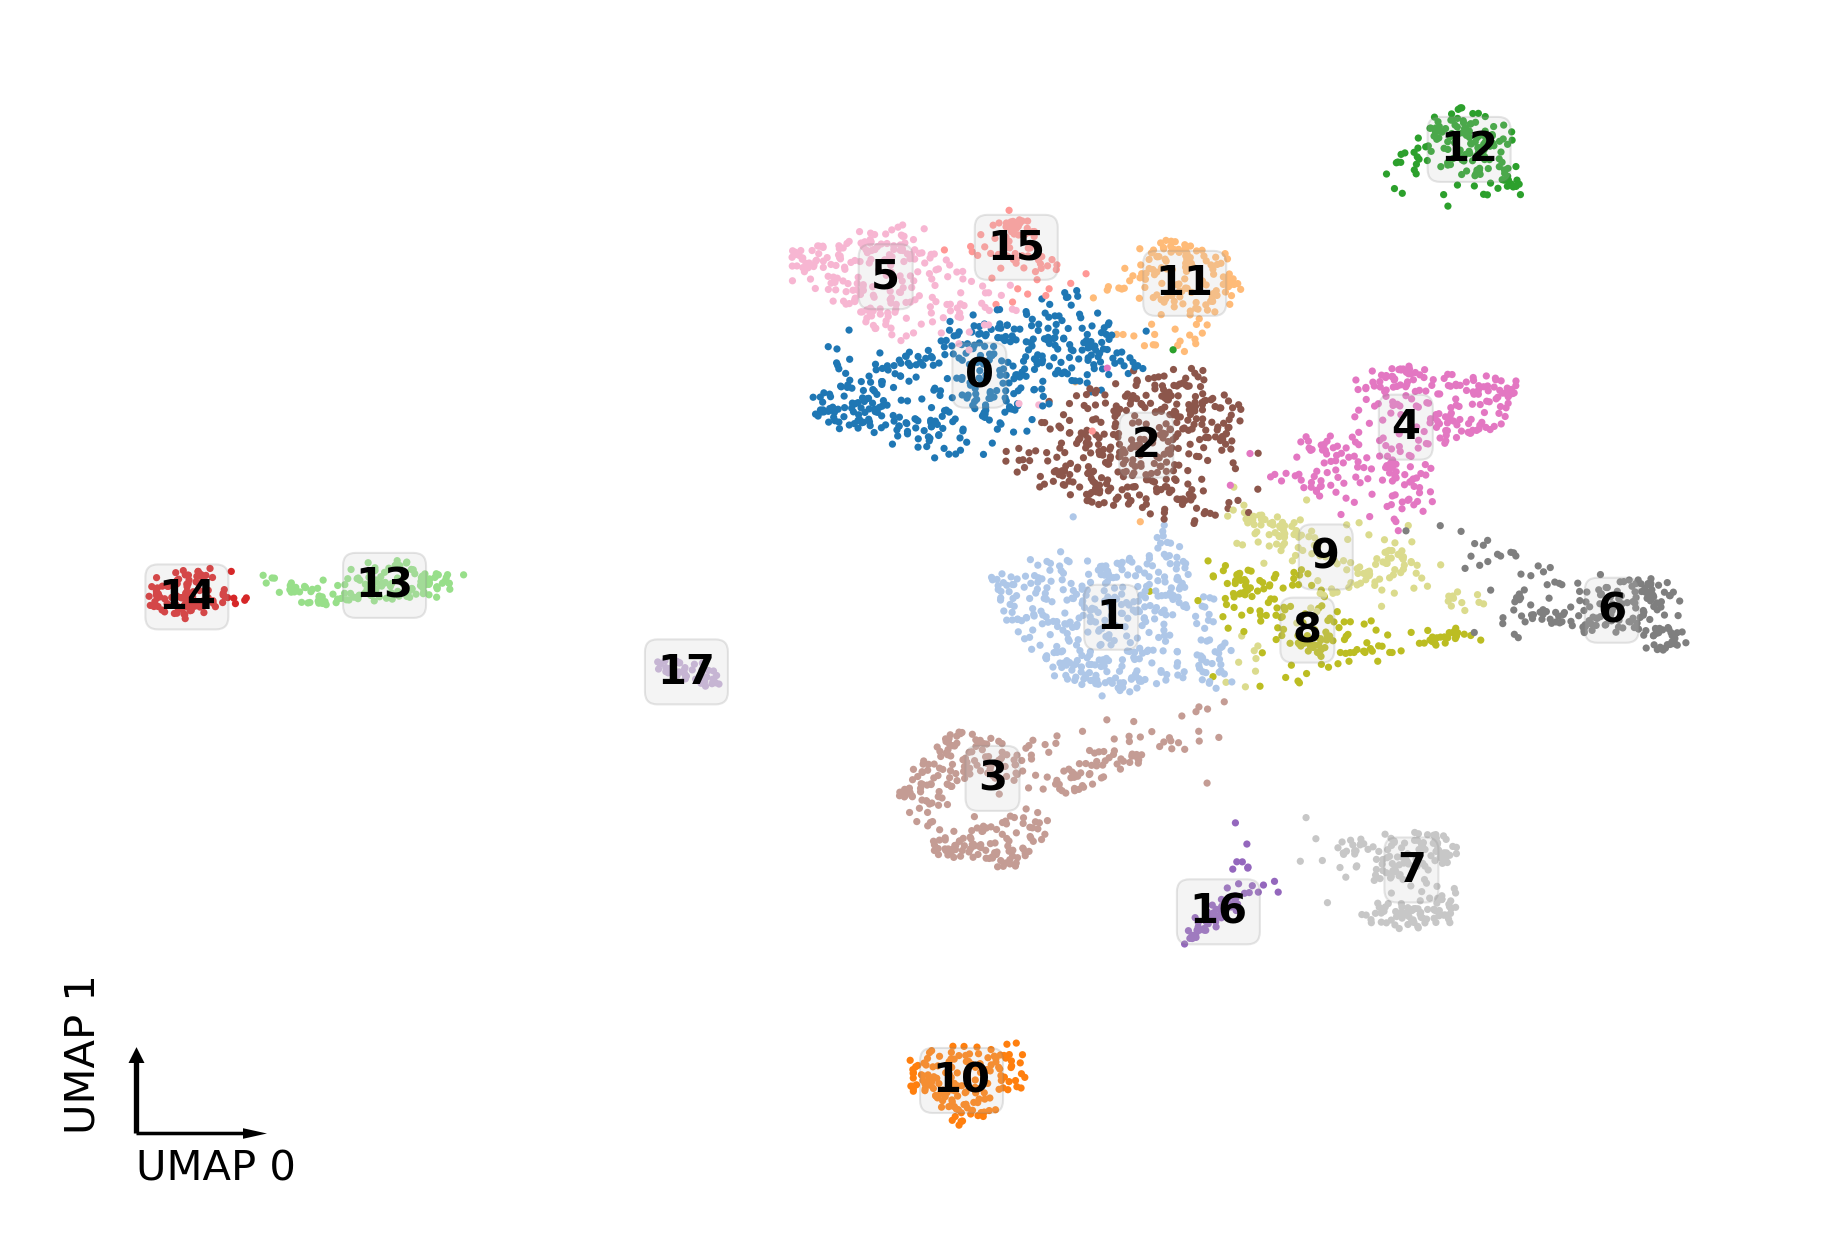

In [20]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=300, constrained_layout=True)
_ = categorical_scatter(data=adata.obs,
                        ax=ax,
                        coord_base='umap',
                        hue='leiden',
                        text_anno='leiden',
                        palette='tab20',
                        labelsize=10,
                        # show_legend=True
                       )


In [21]:
adata.write_h5ad('Tan2021_dipc.h5ad')
